In [18]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import itertools
from keras import backend as K

# LOADING DATA AND PREPROCESSING

In [37]:
data = pd.read_csv("TSLA.csv")

In [20]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [53]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2951,2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2952,2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2953,2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500
2954,2022-03-23,979.940002,1040.699951,976.400024,999.109985,999.109985,40225400
2955,2022-03-24,1009.729980,1024.489990,988.799988,1013.919983,1013.919983,22901900


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2956 non-null   object 
 1   Open       2956 non-null   float64
 2   High       2956 non-null   float64
 3   Low        2956 non-null   float64
 4   Close      2956 non-null   float64
 5   Adj Close  2956 non-null   float64
 6   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 161.8+ KB


In [22]:
# Determine train-test split ratio
train_size = int(len(data) * 0.7)

# Split into train and test datasets
train_data = data[:train_size]
test_data = data[train_size:]

print(f"Train set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")


Train set size: 2069
Test set size: 887


In [23]:
# Determine training-validation split ratio within the train dataset
val_size = int(len(train_data) * 0.2)

# Split train_data into training and validation sets
training_data = train_data[:-val_size]
validation_data = train_data[-val_size:]

print(f"Training set size: {len(training_data)}")
print(f"Validation set size: {len(validation_data)}")


Training set size: 1656
Validation set size: 413


In [24]:
# Convert 'Date' column in training and validation datasets to datetime
training_data['Date'] = pd.to_datetime(training_data['Date'])
validation_data['Date'] = pd.to_datetime(validation_data['Date'])

print(training_data.head())
print(validation_data.head())


        Date   Open   High    Low  Close  Adj Close    Volume
0 2010-06-29  3.800  5.000  3.508  4.778      4.778  93831500
1 2010-06-30  5.158  6.084  4.660  4.766      4.766  85935500
2 2010-07-01  5.000  5.184  4.054  4.392      4.392  41094000
3 2010-07-02  4.600  4.620  3.742  3.840      3.840  25699000
4 2010-07-06  4.000  4.000  3.166  3.222      3.222  34334500
           Date       Open       High        Low      Close  Adj Close  \
1656 2017-01-26  50.858002  51.147999  50.150002  50.501999  50.501999   
1657 2017-01-27  50.276001  50.599998  49.703999  50.590000  50.590000   
1658 2017-01-30  50.506001  51.057999  49.419998  50.125999  50.125999   
1659 2017-01-31  49.848000  51.178001  49.540001  50.386002  50.386002   
1660 2017-02-01  50.610001  50.639999  49.810001  49.848000  49.848000   

        Volume  
1656  15760500  
1657  15831500  
1658  19005500  
1659  20580500  
1660  19794000  


In [25]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Columns to scale
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume']

training_data.loc[:, columns_to_scale] = scaler.fit_transform(training_data[columns_to_scale])

validation_data.loc[:, columns_to_scale] = scaler.transform(validation_data[columns_to_scale])
test_data.loc[:, columns_to_scale] = scaler.transform(test_data[columns_to_scale])

print(training_data.head())
print(validation_data.head())


        Date      Open      High       Low     Close  Adj Close    Volume
0 2010-06-29  0.010533  0.030460  0.009645  0.029936      4.778  0.503377
1 2010-06-30  0.035539  0.050184  0.031347  0.029714      4.766  0.460748
2 2010-07-01  0.032630  0.033808  0.019931  0.022795      4.392  0.218659
3 2010-07-02  0.025264  0.023545  0.014053  0.012581      3.840  0.135544
4 2010-07-06  0.014216  0.012264  0.003202  0.001147      3.222  0.182166
           Date      Open      High       Low     Close  Adj Close    Volume
1656 2017-01-26  0.877067  0.870155  0.888290  0.875925  50.501999  0.081889
1657 2017-01-27  0.866350  0.860184  0.879888  0.877553  50.590000  0.082272
1658 2017-01-30  0.870585  0.868518  0.874538  0.868968  50.125999  0.099408
1659 2017-01-31  0.858469  0.870701  0.876799  0.873779  50.386002  0.107911
1660 2017-02-01  0.872500  0.860912  0.881885  0.863825  49.848000  0.103665


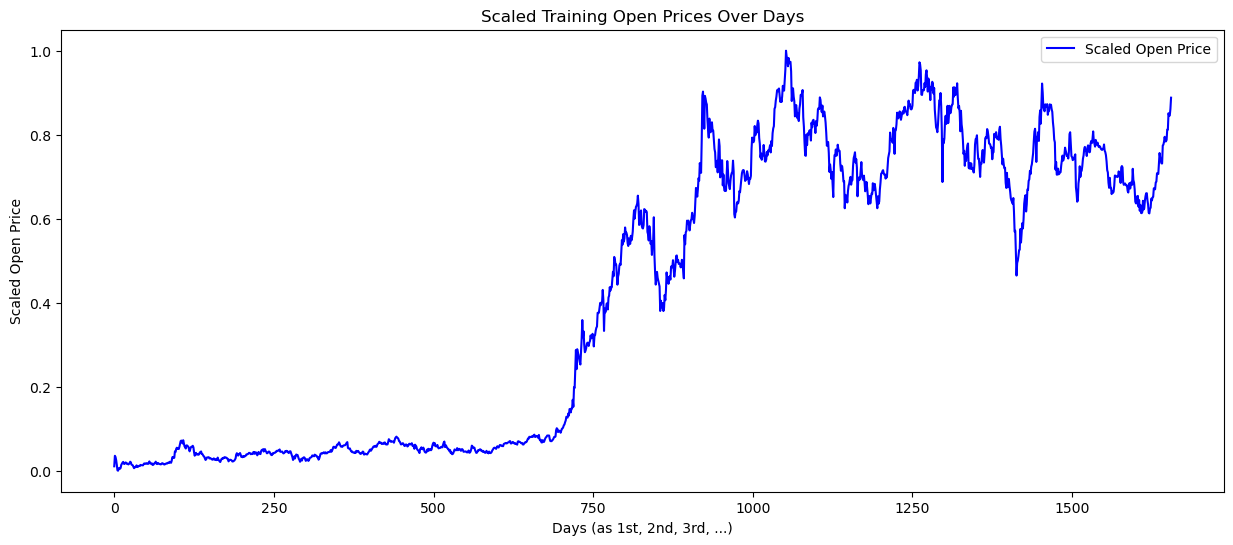

In [26]:
# Visualize scaled training Open prices
plt.subplots(figsize=(15, 6))
plt.plot(training_data['Open'], color='blue', label='Scaled Open Price')
plt.xlabel("Days (as 1st, 2nd, 3rd, ...)")
plt.ylabel("Scaled Open Price")
plt.title("Scaled Training Open Prices Over Days")
plt.legend()
plt.show()


In [27]:
import numpy as np

# Parameters
time_step = 50  # Number of days in each sequence

# Generate sequences for training
scaled_open_prices = training_data['Open'].values
X_train, y_train = [], []
for i in range(len(scaled_open_prices) - time_step):
    X_train.append(scaled_open_prices[i:i + time_step])
    y_train.append(scaled_open_prices[i + time_step])
X_train, y_train = np.array(X_train), np.array(y_train)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (1606, 50)
y_train shape: (1606,)


In [28]:
# Generate sequences for validation
scaled_val_open_prices = validation_data['Open'].values
X_val, y_val = [], []
for i in range(len(scaled_val_open_prices) - time_step):
    X_val.append(scaled_val_open_prices[i:i + time_step])
    y_val.append(scaled_val_open_prices[i + time_step])
X_val, y_val = np.array(X_val), np.array(y_val)

print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_val shape: (363, 50)
y_val shape: (363,)


In [29]:
# Reshape input data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# Reshape X_val and y_val as well
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

print("Shape of X_train after reshape:", X_train.shape)
print("Shape of y_train after reshape:", y_train.shape)
print("Shape of X_val after reshape:", X_val.shape)
print("Shape of y_val after reshape:", y_val.shape)


Shape of X_train after reshape: (1606, 50, 1)
Shape of y_train after reshape: (1606,)
Shape of X_val after reshape: (363, 50, 1)
Shape of y_val after reshape: (363,)


# SIMPLE RNN IMPLEMENTATION

In [63]:
#SIMPLE RNN
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout

# Initialize the RNN
model = Sequential()

model.add(
    SimpleRNN(units=64, 
              activation='tanh', 
              return_sequences=True, 
              input_shape=(X_train.shape[1], 1))  
)
model.add(Dropout(0.3)) 


model.add(
    SimpleRNN(units=64,  
              activation='relu', 
              return_sequences=True)
)
model.add(Dropout(0.25))  


model.add(
    SimpleRNN(units=50,  
              activation='tanh', 
              return_sequences=False)  
)
model.add(Dropout(0.2)) 

model.add(Dense(units=1))


model.compile(
    optimizer='adam', 
    loss='mean_squared_error', 
    metrics=['mae'] 
)


history = model.fit(X_train, y_train, 
                    epochs=30,  
                    batch_size=16,  
                    validation_data=(X_val, y_val)) 


Epoch 1/30
101/101 [==============================] - 13s 61ms/step - loss: 0.0825 - mae: 0.1866 - val_loss: 0.0527 - val_mae: 0.2190
Epoch 2/30
101/101 [==============================] - 5s 45ms/step - loss: 0.0192 - mae: 0.0916 - val_loss: 0.0541 - val_mae: 0.2236
Epoch 3/30
101/101 [==============================] - 5s 52ms/step - loss: 0.0124 - mae: 0.0757 - val_loss: 0.0592 - val_mae: 0.2358
Epoch 4/30
101/101 [==============================] - 5s 54ms/step - loss: 0.0113 - mae: 0.0719 - val_loss: 0.0446 - val_mae: 0.2019
Epoch 5/30
101/101 [==============================] - 6s 56ms/step - loss: 0.0084 - mae: 0.0614 - val_loss: 0.0406 - val_mae: 0.1919
Epoch 6/30
101/101 [==============================] - 5s 54ms/step - loss: 0.0068 - mae: 0.0562 - val_loss: 0.0507 - val_mae: 0.2175
Epoch 7/30
101/101 [==============================] - 6s 55ms/step - loss: 0.0070 - mae: 0.0578 - val_loss: 0.0247 - val_mae: 0.1474
Epoch 8/30
101/101 [==============================] - 5s 49ms/step -

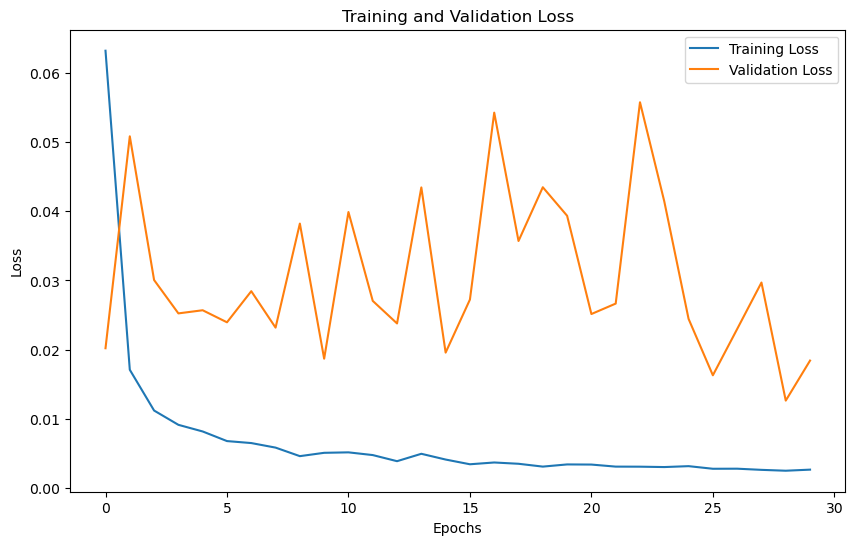

In [38]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [39]:
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss (MSE): {val_loss:.4f}")
print(f"Validation MAE: {val_mae:.4f}")


Validation Loss (MSE): 0.0184
Validation MAE: 0.1265


Validation MAPE: 11.85%


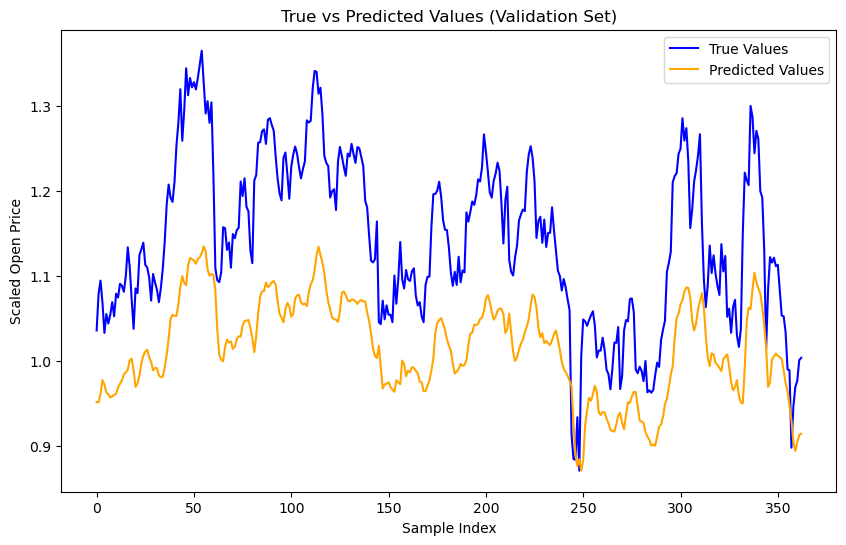

In [40]:
import numpy as np

# Calculate Mean Absolute Percentage Error (MAPE)
y_val_pred = model.predict(X_val, verbose=0)
mape = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100

print(f"Validation MAPE: {mape:.2f}%")

# Visualize true vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='True Values', color='blue')
plt.plot(y_val_pred, label='Predicted Values', color='orange')
plt.title('True vs Predicted Values (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Scaled Open Price')
plt.legend()
plt.show()


# LSTM IMPLEMENTATION

In [41]:
#LSTM Model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model_lstm = Sequential()

model_lstm.add(
    LSTM(units=64, 
         activation='tanh', 
         return_sequences=True, 
         input_shape=(X_train.shape[1], 1))
)
model_lstm.add(Dropout(0.3))  


model_lstm.add(
    LSTM(units=64, 
         activation='tanh', 
         return_sequences=True)
)
model_lstm.add(Dropout(0.3))


model_lstm.add(
    LSTM(units=50, 
         activation='tanh', 
         return_sequences=False)
)
model_lstm.add(Dropout(0.3))

model_lstm.add(Dense(units=1)) 

model_lstm.compile(
    optimizer='adam', 
    loss='mean_squared_error', 
    metrics=['mae']
)

history_lstm = model_lstm.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=16, 
    validation_data=(X_val, y_val)
)


Epoch 1/30
101/101 [==============================] - 21s 121ms/step - loss: 0.0164 - mae: 0.0809 - val_loss: 0.0111 - val_mae: 0.0844
Epoch 2/30
101/101 [==============================] - 9s 94ms/step - loss: 0.0065 - mae: 0.0537 - val_loss: 0.0217 - val_mae: 0.1300
Epoch 3/30
101/101 [==============================] - 10s 96ms/step - loss: 0.0055 - mae: 0.0498 - val_loss: 0.0150 - val_mae: 0.1039
Epoch 4/30
101/101 [==============================] - 10s 95ms/step - loss: 0.0055 - mae: 0.0491 - val_loss: 0.0104 - val_mae: 0.0824
Epoch 5/30
101/101 [==============================] - 9s 94ms/step - loss: 0.0052 - mae: 0.0476 - val_loss: 0.0287 - val_mae: 0.1552
Epoch 6/30
101/101 [==============================] - 10s 95ms/step - loss: 0.0052 - mae: 0.0483 - val_loss: 0.0068 - val_mae: 0.0647
Epoch 7/30
101/101 [==============================] - 9s 94ms/step - loss: 0.0047 - mae: 0.0460 - val_loss: 0.0142 - val_mae: 0.1023
Epoch 8/30
101/101 [==============================] - 10s 95ms/s

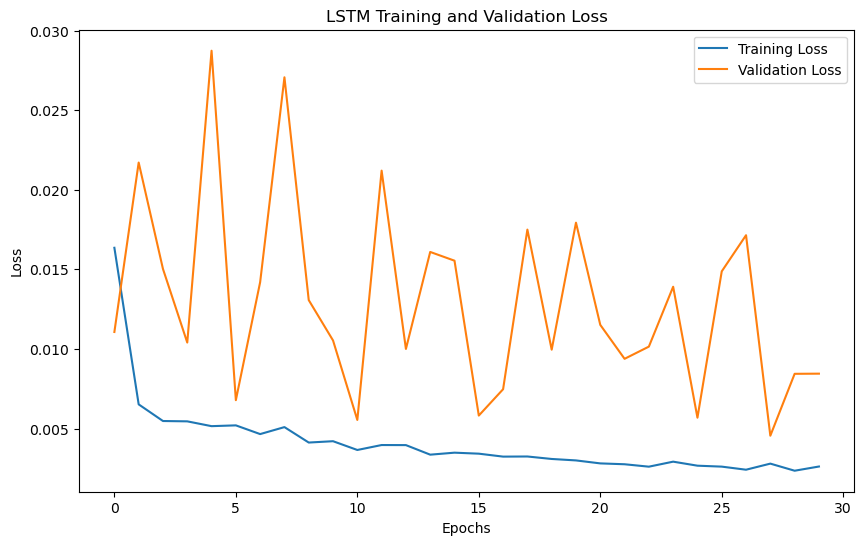

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [54]:
# Evaluate the model on validation data
val_loss, val_mae = model_lstm.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss (MSE): {val_loss:.4f}")
print(f"Validation MAE: {val_mae:.4f}")

Validation Loss (MSE): 0.0085
Validation MAE: 0.0818


In [43]:
y_val_pred_lstm = model_lstm.predict(X_val, verbose=0)
mape_lstm = np.mean(np.abs((y_val - y_val_pred_lstm) / y_val)) * 100
print(f"Validation MAPE for LSTM: {mape_lstm:.2f}%")


Validation MAPE for LSTM: 10.21%


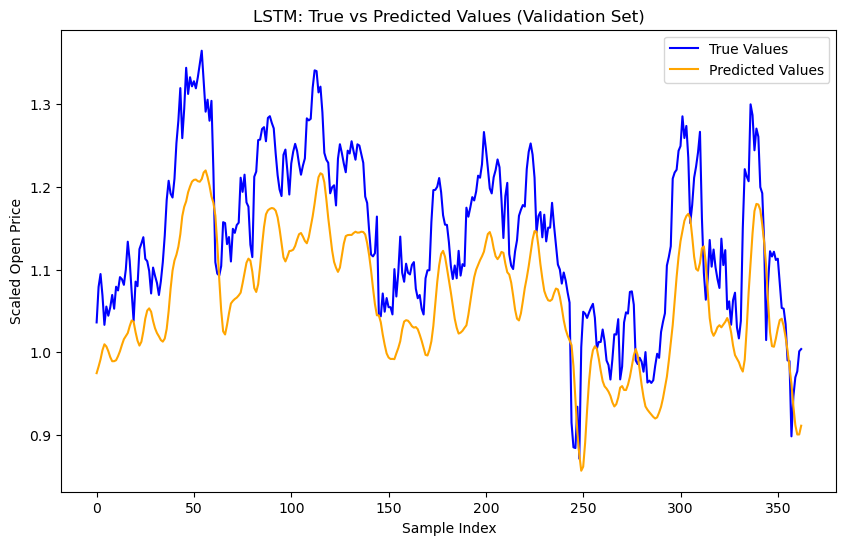

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='True Values', color='blue')
plt.plot(y_val_pred_lstm, label='Predicted Values', color='orange')
plt.title('LSTM: True vs Predicted Values (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Scaled Open Price')
plt.legend()
plt.show()


# GRU IMPLEMENTATION

In [45]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

# Initialize the GRU model
gru_model = Sequential()


gru_model.add(GRU(units=50, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(Dropout(0.2))


gru_model.add(GRU(units=50, activation='tanh', return_sequences=True))
gru_model.add(Dropout(0.2))


gru_model.add(GRU(units=50, activation='tanh'))
gru_model.add(Dropout(0.2))


gru_model.add(Dense(units=1))


gru_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


gru_history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32
)


Epoch 1/30
51/51 [==============================] - 18s 164ms/step - loss: 0.0314 - mae: 0.1154 - val_loss: 0.0039 - val_mae: 0.0487
Epoch 2/30
51/51 [==============================] - 6s 121ms/step - loss: 0.0050 - mae: 0.0463 - val_loss: 0.0057 - val_mae: 0.0607
Epoch 3/30
51/51 [==============================] - 7s 128ms/step - loss: 0.0047 - mae: 0.0454 - val_loss: 0.0044 - val_mae: 0.0523
Epoch 4/30
51/51 [==============================] - 6s 119ms/step - loss: 0.0042 - mae: 0.0433 - val_loss: 0.0058 - val_mae: 0.0615
Epoch 5/30
51/51 [==============================] - 6s 124ms/step - loss: 0.0038 - mae: 0.0410 - val_loss: 0.0034 - val_mae: 0.0452
Epoch 6/30
51/51 [==============================] - 6s 121ms/step - loss: 0.0035 - mae: 0.0395 - val_loss: 0.0040 - val_mae: 0.0498
Epoch 7/30
51/51 [==============================] - 6s 117ms/step - loss: 0.0033 - mae: 0.0385 - val_loss: 0.0072 - val_mae: 0.0713
Epoch 8/30
51/51 [==============================] - 6s 124ms/step - loss: 0

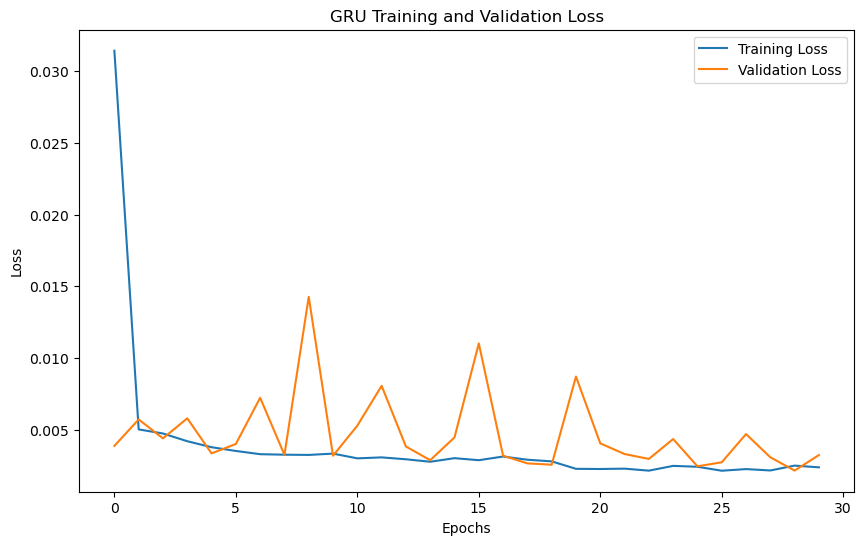

In [46]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(gru_history.history['loss'], label='Training Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title('GRU Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [61]:
#generating tables for true vs predicted values
rnn_predictions = model.predict(X_val)  
lstm_predictions = model_lstm.predict(X_val)
gru_predictions = gru_model.predict(X_val)

y_val_placeholder = np.zeros((len(y_val), 5))  
rnn_placeholder = np.zeros((len(rnn_predictions), 5))
lstm_placeholder = np.zeros((len(lstm_predictions), 5))
gru_placeholder = np.zeros((len(gru_predictions), 5))

y_val_placeholder[:, 0] = y_val.flatten()  
rnn_placeholder[:, 0] = rnn_predictions.flatten()
lstm_placeholder[:, 0] = lstm_predictions.flatten()
gru_placeholder[:, 0] = gru_predictions.flatten()

y_val_original = scaler.inverse_transform(y_val_placeholder)[:, 0]  
rnn_predictions_original = scaler.inverse_transform(rnn_placeholder)[:, 0]
lstm_predictions_original = scaler.inverse_transform(lstm_placeholder)[:, 0]
gru_predictions_original = scaler.inverse_transform(gru_placeholder)[:, 0]

date_column = validation_data['Date'].values[:len(y_val)]


rnn_comparison = pd.DataFrame({
    "Date": date_column,
    "Actual Open Price": y_val_original.flatten(),
    "Predicted Open Price (RNN)": rnn_predictions_original.flatten()
})

lstm_comparison = pd.DataFrame({
    "Date": date_column,
    "Actual Open Price": y_val_original.flatten(),
    "Predicted Open Price (LSTM)": lstm_predictions_original.flatten()
})
gru_comparison = pd.DataFrame({
    "Date": date_column,
    "Actual Open Price": y_val_original.flatten(),
    "Predicted Open Price (LSTM)": gru_predictions_original.flatten()
})

rnn_comparison.to_csv("RNN_Comparison_with_Date.csv", index=False)
lstm_comparison.to_csv("LSTM_Comparison_with_Date.csv", index=False)
gru_comparison.to_csv("GRU_Comparison_with_Date.csv", index=False)

print("RNN Comparison Table:")
print(rnn_comparison.head())

print("\nLSTM Comparison Table:")
print(lstm_comparison.head())
print("\nGRU Comparison Table:")
print(gru_comparison.head())

12/12 [==============================] - 0s 21ms/step
RNN Comparison Table:
        Date  Actual Open Price  Predicted Open Price (RNN)
0 2017-01-26          59.500000                   54.927184
1 2017-01-27          61.830002                   54.916696
2 2017-01-30          62.675999                   55.458377
3 2017-01-31          61.268002                   56.329715
4 2017-02-01          59.340000                   56.047653

LSTM Comparison Table:
        Date  Actual Open Price  Predicted Open Price (LSTM)
0 2017-01-26          59.500000                    56.168091
1 2017-01-27          61.830002                    56.598675
2 2017-01-30          62.675999                    57.073973
3 2017-01-31          61.268002                    57.676883
4 2017-02-01          59.340000                    58.063723

GRU Comparison Table:
        Date  Actual Open Price  Predicted Open Price (LSTM)
0 2017-01-26          59.500000                    56.425773
1 2017-01-27          61.8300

In [47]:
# Evaluate on validation set
val_loss, val_mae = gru_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss (MSE) for GRU: {val_loss:.4f}")
print(f"Validation MAE for GRU: {val_mae:.4f}")

# Calculate MAPE
y_val_pred = gru_model.predict(X_val)
mape_gru = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100
print(f"Validation MAPE for GRU: {mape_gru:.2f}%")


Validation Loss (MSE) for GRU: 0.0032
Validation MAE for GRU: 0.0459
12/12 [==============================] - 3s 44ms/step
Validation MAPE for GRU: 9.21%


# Plot true vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='True Values', color='blue')
plt.plot(y_val_pred, label='Predicted Values', color='orange')
plt.title('GRU: True vs Predicted Values (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Scaled Open Price')
plt.legend()
plt.show()


In [30]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


# Hyperparameter optimization

In [15]:
import itertools
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM
from keras.optimizers import Adam

# Hyperparameter grid
param_grid = {
    "units": [32, 64],
    "dropout_rate": [0.2, 0.3],
    "batch_size": [32, 64],
    "learning_rate": [0.0001, 0.001],
    "num_layers": [1, 2],
    "activation": ['tanh', 'relu']
}


def build_vanilla_rnn(input_shape, units, dropout_rate, num_layers, activation, learning_rate):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(SimpleRNN(units=units, activation=activation, return_sequences=(i < num_layers - 1), input_shape=input_shape))
        else:
            model.add(SimpleRNN(units=units, activation=activation, return_sequences=(i < num_layers - 1)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse", metrics=["mae"])
    return model

def build_gru(input_shape, units, dropout_rate, num_layers, activation, learning_rate):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(GRU(units=units, activation=activation, return_sequences=(i < num_layers - 1), input_shape=input_shape))
        else:
            model.add(GRU(units=units, activation=activation, return_sequences=(i < num_layers - 1)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse", metrics=["mae"])
    return model

def build_lstm(input_shape, units, dropout_rate, num_layers, activation, learning_rate):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(LSTM(units=units, activation=activation, return_sequences=(i < num_layers - 1), input_shape=input_shape))
        else:
            model.add(LSTM(units=units, activation=activation, return_sequences=(i < num_layers - 1)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse", metrics=["mae"])
    return model

# Optimization function
def optimize_model(build_fn, input_shape, X_train, y_train, X_val, y_val):
    best_model = None
    best_params = None
    best_val_loss = float('inf')
    results = []
    total_combinations = len(list(itertools.product(*param_grid.values())))
    current_combination = 0

    for params in itertools.product(*param_grid.values()):
        current_combination += 1
        units, dropout_rate, batch_size, learning_rate, num_layers, activation = params

        
        print(f"\nTesting combination {current_combination}/{total_combinations}:")
        print(f"Units: {units}, Dropout Rate: {dropout_rate}, Batch Size: {batch_size}, "
              f"Learning Rate: {learning_rate}, Num Layers: {num_layers}, Activation: {activation}")

       
        model = build_fn(input_shape, units, dropout_rate, num_layers, activation, learning_rate)
        
       
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10,
                            batch_size=batch_size, verbose=0, callbacks=[early_stopping])
        
      
        val_loss = min(history.history['val_loss'])
        print(f"Validation Loss: {val_loss:.4f}")

        results.append((params, val_loss))
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            best_params = params
            model.save(f"best_model_{build_fn.__name__}_{best_val_loss:.4f}.keras")
            print(f"New best model found with Validation Loss: {val_loss:.4f}. Model saved.")

        # Clear session to free memory
        K.clear_session()
    
    print("\nOptimization completed.")
    print(f"Best Parameters: {best_params}")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    
    return best_model, best_params, results


# Input shape for models
input_shape = (X_train.shape[1], 1)

# Run optimization for all models
best_vanilla_rnn, best_params_rnn, results_rnn = optimize_model(build_vanilla_rnn, input_shape, X_train, y_train, X_val, y_val)
best_gru, best_params_gru, results_gru = optimize_model(build_gru, input_shape, X_train, y_train, X_val, y_val)
best_lstm, best_params_lstm, results_lstm = optimize_model(build_lstm, input_shape, X_train, y_train, X_val, y_val)

# Summarize best results
print("Best Vanilla RNN:", best_params_rnn)
print("Best GRU:", best_params_gru)
print("Best LSTM:", best_params_lstm)



Testing combination 1/64:
Units: 32, Dropout Rate: 0.2, Batch Size: 32, Learning Rate: 0.0001, Num Layers: 1, Activation: tanh
Validation Loss: 0.0600
New best model found with Validation Loss: 0.0600. Model saved.

Testing combination 2/64:
Units: 32, Dropout Rate: 0.2, Batch Size: 32, Learning Rate: 0.0001, Num Layers: 1, Activation: relu
Validation Loss: 0.0120
New best model found with Validation Loss: 0.0120. Model saved.

Testing combination 3/64:
Units: 32, Dropout Rate: 0.2, Batch Size: 32, Learning Rate: 0.0001, Num Layers: 2, Activation: tanh
Validation Loss: 0.0038
New best model found with Validation Loss: 0.0038. Model saved.

Testing combination 4/64:
Units: 32, Dropout Rate: 0.2, Batch Size: 32, Learning Rate: 0.0001, Num Layers: 2, Activation: relu
Validation Loss: 0.0161

Testing combination 5/64:
Units: 32, Dropout Rate: 0.2, Batch Size: 32, Learning Rate: 0.001, Num Layers: 1, Activation: tanh
Validation Loss: 0.0068

Testing combination 6/64:
Units: 32, Dropout Rat

# Evaluating best model on test set

In [49]:
# Prepare test sequences
scaled_test_open_prices = test_data['Open'].values
X_test, y_test = [], []
for i in range(len(scaled_test_open_prices) - time_step):
    X_test.append(scaled_test_open_prices[i:i + time_step])
    y_test.append(scaled_test_open_prices[i + time_step])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Evaluate each best model on test data
from keras.models import load_model

from keras.models import load_model

# Load the best Vanilla RNN model
vanilla_rnn_model = load_model("best_model_build_vanilla_rnn_0.0036.keras")
test_loss_rnn, test_mae_rnn = vanilla_rnn_model.evaluate(X_test, y_test)
print(f"Vanilla RNN - Test Loss: {test_loss_rnn:.4f}, Test MAE: {test_mae_rnn:.4f}")

# Load the best GRU model
gru_model = load_model("best_model_build_gru_0.0039.keras")
test_loss_gru, test_mae_gru = gru_model.evaluate(X_test, y_test)
print(f"GRU - Test Loss: {test_loss_gru:.4f}, Test MAE: {test_mae_gru:.4f}")

# Load the best LSTM model
lstm_model = load_model("best_model_build_lstm_0.0037.keras")
test_loss_lstm, test_mae_lstm = lstm_model.evaluate(X_test, y_test)
print(f"LSTM - Test Loss: {test_loss_lstm:.4f}, Test MAE: {test_mae_lstm:.4f}")



27/27 [==============================] - 1s 6ms/step - loss: 1.1666 - mae: 0.7362
Vanilla RNN - Test Loss: 1.1666, Test MAE: 0.7362
27/27 [==============================] - 2s 22ms/step - loss: 58.1671 - mae: 5.1786
GRU - Test Loss: 58.1671, Test MAE: 5.1786
27/27 [==============================] - 2s 19ms/step - loss: 77.7932 - mae: 6.0402
LSTM - Test Loss: 77.7932, Test MAE: 6.0402


In [31]:
import os
print(os.listdir('.'))

["(Fieser and Fieser's Reagents for Organic Synthesis vol. 1) Mary Fieser - Volume 1, Fiesers' Reagents for Organic Synthesis-Wiley-Interscience (1967)(Z-Lib.io).djvu", "(Fieser and Fieser's Reagents for Organic Synthesis vol. 1) Mary Fieser - Volume 1, Fiesers' Reagents for Organic Synthesis-Wiley-Interscience (1967)(Z-Lib.io).pdf", '.ipynb_checkpoints', '.RData', '.Rhistory', '.~car-sales.csv', '0A_Python_Prerequisites.ipynb', '1. Standard notations for Deep Learning.pdf', '100+Days+of+Python+Check+Off+Posters.pdf', '10th.jpeg', '11zon_merged-PDF.pdf', '12+Rules+to+Learn+to+Code+eBook-Copyright+App+Brewery.pdf', '1219680.jpg', '1593771999phpC5p1d6.pdf', '196389122 (1)', '196389122 (1).zip', '2. Binary_Classification.pdf', '2024 m-accounting.pdf', '2024-Library-Assistant-PD(StudentCasual)-updat.pdf', '2411615.jpg', '260352816', '260352816.zip', '2748948.webp', '3. Logistic_Regression.pdf', '30.8.24 Volunteer_Role_Description_Social_Media_Officer.pdf', '3880709c-7295-4ab9-8e35-5128534f

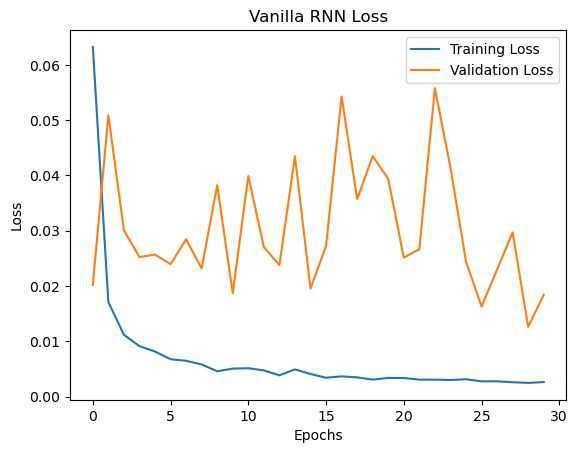

In [50]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call this for each model's training history
plot_training_history(history, 'Vanilla RNN') 


27/27 [==============================] - 1s 7ms/step - loss: 1.1666 - mae: 0.7362
Vanilla RNN - Test Loss: 1.1666, Test MAE: 0.7362, Test MAPE: 8.92%
27/27 [==============================] - 2s 21ms/step - loss: 58.1671 - mae: 5.1786
GRU - Test Loss: 58.1671, Test MAE: 5.1786, Test MAPE: 42.94%
27/27 [==============================] - 1s 11ms/step - loss: 77.7932 - mae: 6.0402
LSTM - Test Loss: 77.7932, Test MAE: 6.0402, Test MAPE: 50.12%


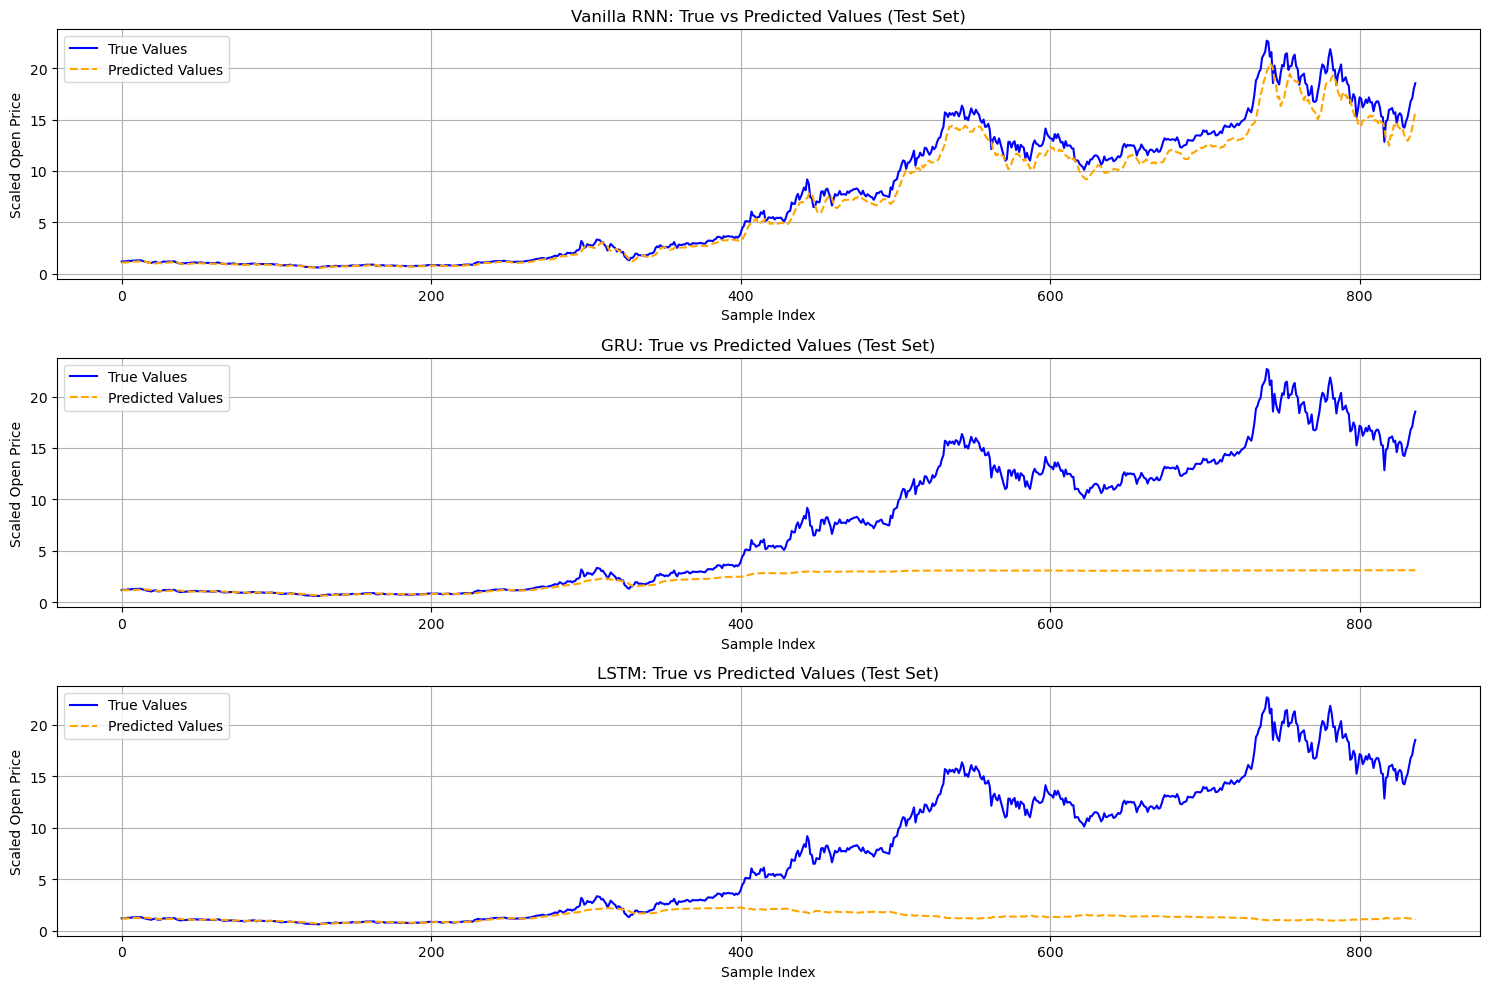

In [51]:
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Load the best Vanilla RNN model
vanilla_rnn_model = load_model("best_model_build_vanilla_rnn_0.0036.keras")
y_test_pred_rnn = vanilla_rnn_model.predict(X_test)
test_loss_rnn, test_mae_rnn = vanilla_rnn_model.evaluate(X_test, y_test)
mape_rnn = mean_absolute_percentage_error(y_test, y_test_pred_rnn) * 100
print(f"Vanilla RNN - Test Loss: {test_loss_rnn:.4f}, Test MAE: {test_mae_rnn:.4f}, Test MAPE: {mape_rnn:.2f}%")

# Load the best GRU model
gru_model = load_model("best_model_build_gru_0.0039.keras")
y_test_pred_gru = gru_model.predict(X_test)
test_loss_gru, test_mae_gru = gru_model.evaluate(X_test, y_test)
mape_gru = mean_absolute_percentage_error(y_test, y_test_pred_gru) * 100
print(f"GRU - Test Loss: {test_loss_gru:.4f}, Test MAE: {test_mae_gru:.4f}, Test MAPE: {mape_gru:.2f}%")

# Load the best LSTM model
lstm_model = load_model("best_model_build_lstm_0.0037.keras")
y_test_pred_lstm = lstm_model.predict(X_test)
test_loss_lstm, test_mae_lstm = lstm_model.evaluate(X_test, y_test)
mape_lstm = mean_absolute_percentage_error(y_test, y_test_pred_lstm) * 100
print(f"LSTM - Test Loss: {test_loss_lstm:.4f}, Test MAE: {test_mae_lstm:.4f}, Test MAPE: {mape_lstm:.2f}%")

# Plot true vs predicted values for each model
plt.figure(figsize=(15, 10))

# Vanilla RNN
plt.subplot(3, 1, 1)
plt.plot(y_test, label="True Values", color="blue")
plt.plot(y_test_pred_rnn, label="Predicted Values", color="orange", linestyle="--")
plt.title("Vanilla RNN: True vs Predicted Values (Test Set)")
plt.xlabel("Sample Index")
plt.ylabel("Scaled Open Price")
plt.legend()
plt.grid()

# GRU
plt.subplot(3, 1, 2)
plt.plot(y_test, label="True Values", color="blue")
plt.plot(y_test_pred_gru, label="Predicted Values", color="orange", linestyle="--")
plt.title("GRU: True vs Predicted Values (Test Set)")
plt.xlabel("Sample Index")
plt.ylabel("Scaled Open Price")
plt.legend()
plt.grid()

# LSTM
plt.subplot(3, 1, 3)
plt.plot(y_test, label="True Values", color="blue")
plt.plot(y_test_pred_lstm, label="Predicted Values", color="orange", linestyle="--")
plt.title("LSTM: True vs Predicted Values (Test Set)")
plt.xlabel("Sample Index")
plt.ylabel("Scaled Open Price")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# Next day prediction

1/1 [==============================] - 0s 271ms/step
Predicted Open Price for the Next Day: 16.48


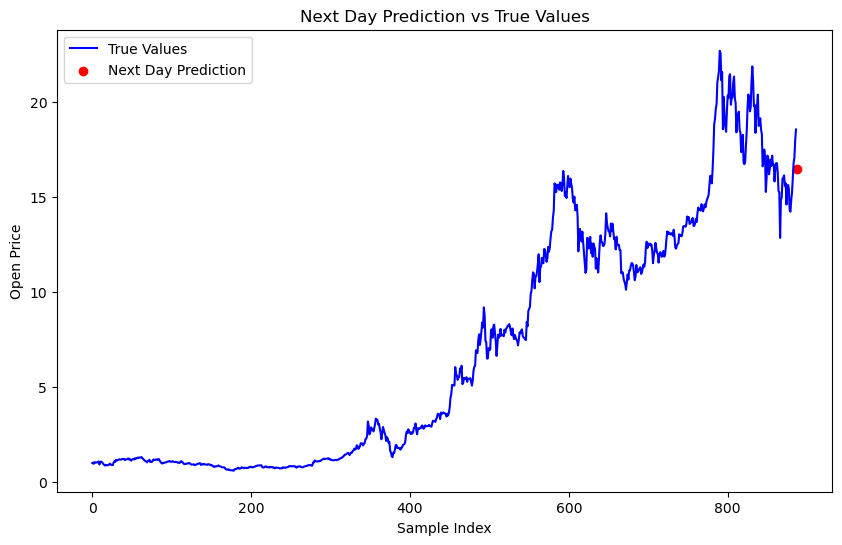

In [52]:

open_scaler = MinMaxScaler(feature_range=(0, 1))
training_data['Open_scaled'] = open_scaler.fit_transform(training_data[['Open']])


last_50_prices = test_data['Open'].values[-50:]  # Get the last 50 open prices
last_50_scaled = open_scaler.transform(last_50_prices.reshape(-1, 1))  # Scale the prices
X_input = np.reshape(last_50_scaled, (1, 50, 1))  # Reshape for RNN input

# Load the Best Vanilla RNN Model
best_vanilla_rnn_model = load_model("best_model_build_vanilla_rnn_0.0036.keras")

# Predict Next Day's Open Price
next_day_scaled_price = best_vanilla_rnn_model.predict(X_input)
next_day_price = open_scaler.inverse_transform(next_day_scaled_price)  # Inverse transform to original scale

#  Output the Result
print(f"Predicted Open Price for the Next Day: {next_day_price[0, 0]:.2f}")


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_data['Open'].values, label="True Values", color="blue")
plt.scatter(len(test_data['Open']), next_day_price, color="red", label="Next Day Prediction")
plt.xlabel("Sample Index")
plt.ylabel("Open Price")
plt.title("Next Day Prediction vs True Values")
plt.legend()
plt.show()


In [62]:
# Find the actual open price for the next day
actual_next_day_open_price = test_data['Open'].values[-1]  # Last entry in the test data
print(f"Actual Open Price for the Next Day: {actual_next_day_open_price}")


Actual Open Price for the Next Day: 18.53390012153353
